# Activity 3: Mountain Rescue System KPI Analysis
## Performance Evaluation of Basic vs Extended Mode

This notebook analyzes the performance of the Mountain Rescue Robot system comparing Basic Mode and Extended Mode operations using key performance indicators (KPIs).

## Key Performance Indicators (KPIs)

The following KPIs will be analyzed to evaluate system performance:

1. **Rescue Rate**: Percentage of persons rescued over time
2. **Response Time**: Average time from person spawning to rescue initiation
3. **Energy Efficiency**: Battery consumption per rescue operation
4. **Communication Efficiency**: Messages sent per successful rescue (Extended Mode)
5. **Agent Utilization**: Percentage of time agents spend in active vs idle states
6. **Mission Success Rate**: Percentage of missions completed successfully

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Add src directory to path - updated for new location
src_path = os.path.join(os.path.dirname(os.getcwd()), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Import our simulation components
from model import MountainRescueModel
from agents import FirstAidRobot, ExplorerDrone, Person

## Simulation Configuration

We'll run simulations in both Basic and Extended modes to compare performance.

In [2]:
# Simulation parameters
SIMULATION_PARAMS = {
    'width': 15,
    'height': 15,
    'n_robots': 4,
    'n_drones': 3,
    'n_persons': 8,
    'seed': 42,
    'max_steps': 300
}

# Extended mode specific parameters
EXTENDED_PARAMS = {
    'spawn_interval': 30,  # New persons every 30 steps
    'max_persons': 15      # Maximum persons in environment
}

print("Simulation Configuration:")
print(f"Environment: {SIMULATION_PARAMS['width']}x{SIMULATION_PARAMS['height']}")
print(f"Agents: {SIMULATION_PARAMS['n_robots']} robots, {SIMULATION_PARAMS['n_drones']} drones")
print(f"Initial persons: {SIMULATION_PARAMS['n_persons']}")
print(f"Simulation steps: {SIMULATION_PARAMS['max_steps']}")

Simulation Configuration:
Environment: 15x15
Agents: 4 robots, 3 drones
Initial persons: 8
Simulation steps: 300


## Data Collection Function

Function to run simulations and collect performance data.

In [3]:
def run_simulation(mode: str, params: Dict) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Run a simulation in specified mode and collect data.
    
    Args:
        mode: 'basic' or 'extended'
        params: Simulation parameters
    
    Returns:
        Tuple of (model_data, agent_data, summary_stats)
    """
    print(f"\n🚀 Starting {mode.upper()} mode simulation...")
    
    # Create model with appropriate parameters
    model_params = params.copy()
    model_params['mode'] = mode
    
    # Remove max_steps from model_params as it's not accepted by the model
    max_steps = model_params.pop('max_steps', 200)
    
    if mode == 'extended':
        model_params.update(EXTENDED_PARAMS)
    
    model = MountainRescueModel(**model_params)
    
    # Run simulation
    for step in range(max_steps):
        model.step()
        
        # Progress indicator
        if (step + 1) % 50 == 0:
            print(f"  Step {step + 1}/{max_steps} completed")
    
    # Collect data
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    
    # Calculate summary statistics
    summary_stats = {
        'mode': mode,
        'total_persons_spawned': model.total_persons_spawned,
        'total_rescued': model.rescued_count,
        'rescue_rate': model.rescued_count / model.total_persons_spawned if model.total_persons_spawned > 0 else 0,
        'simulation_steps': model.steps,
        'avg_response_time': model.calculate_average_response_time(),
        'communication_efficiency': model.calculate_communication_efficiency() if mode == 'extended' else 0,
    }
    
    print(f"✅ {mode.upper()} mode simulation completed!")
    print(f"   Persons rescued: {summary_stats['total_rescued']}/{summary_stats['total_persons_spawned']}")
    print(f"   Rescue rate: {summary_stats['rescue_rate']:.2%}")
    
    return model_data, agent_data, summary_stats

## Run Simulations

Execute both Basic and Extended mode simulations to collect performance data.

In [4]:
# Run Basic Mode simulation
basic_model_data, basic_agent_data, basic_summary = run_simulation('basic', SIMULATION_PARAMS)

# Run Extended Mode simulation
extended_model_data, extended_agent_data, extended_summary = run_simulation('extended', SIMULATION_PARAMS)


🚀 Starting BASIC mode simulation...
🆘 Spawned 8 persons across the mountain
🏔️ Mountain Rescue Model initialized:
   Mode: basic
   Grid: 15x15
   Agents: 4 robots, 3 drones, 8 persons
   Base: (0, 0)
🟦 Robot 3: IDLE → EXPLORING (Starting mission)
🟢 Drone 6: IDLE → FLYING (Launching mission)
🟢 Drone 5: IDLE → FLYING (Launching mission)
🟦 Robot 4: IDLE → EXPLORING (Starting mission)
🟦 Robot 2: IDLE → EXPLORING (Starting mission)
🟦 Robot 1: IDLE → EXPLORING (Starting mission)
🟢 Drone 7: IDLE → FLYING (Launching mission)
🔍 Robot 4: EXPLORING at (0, 0) (Battery: 100)
🚶 Robot 4: (0, 0) → (0, 1) (Alt: 0.0K MASL, Cost: 1, Battery: 99)
🔍 Robot 2: EXPLORING at (0, 0) (Battery: 100)
🚶 Robot 2: (0, 0) → (1, 0) (Alt: 0.0K MASL, Cost: 1, Battery: 99)
✈️ Drone 6: FLYING reconnaissance at (0, 0) (Battery: 150)
✈️ Drone 6: Flying (0, 0) → (1, 0) (Alt: 0.0K MASL, Battery: 148)
✈️ Drone 7: FLYING reconnaissance at (0, 0) (Battery: 150)
✈️ Drone 7: Flying (0, 0) → (1, 1) (Alt: 0.0K MASL, Battery: 148)
🔍

## Data Processing and Analysis

Process the collected data to extract meaningful insights.

In [5]:
# Add mode labels to dataframes
basic_model_data['Mode'] = 'Basic'
extended_model_data['Mode'] = 'Extended'

# Combine datasets for comparison
combined_model_data = pd.concat([basic_model_data, extended_model_data], ignore_index=True)

# Display summary statistics
print("\n📊 SIMULATION SUMMARY")
print("=" * 50)
print(f"{'Metric':<25} {'Basic Mode':<12} {'Extended Mode':<12} {'Improvement':<12}")
print("-" * 50)

# Calculate improvements
rescue_rate_improvement = (extended_summary['rescue_rate'] - basic_summary['rescue_rate']) / basic_summary['rescue_rate'] * 100 if basic_summary['rescue_rate'] > 0 else 0
response_time_improvement = (basic_summary['avg_response_time'] - extended_summary['avg_response_time']) / basic_summary['avg_response_time'] * 100 if basic_summary['avg_response_time'] > 0 else 0

print(f"{'Rescue Rate':<25} {basic_summary['rescue_rate']:<12.2%} {extended_summary['rescue_rate']:<12.2%} {rescue_rate_improvement:<+12.1f}%")
print(f"{'Total Rescued':<25} {basic_summary['total_rescued']:<12} {extended_summary['total_rescued']:<12} {extended_summary['total_rescued'] - basic_summary['total_rescued']:<+12}")
print(f"{'Avg Response Time':<25} {basic_summary['avg_response_time']:<12.1f} {extended_summary['avg_response_time']:<12.1f} {response_time_improvement:<+12.1f}%")
print(f"{'Communication Eff.':<25} {'N/A':<12} {extended_summary['communication_efficiency']:<12.1f} {'N/A':<12}")

# Save processed data
basic_model_data.to_csv('basic_mode_results.csv', index=False)
extended_model_data.to_csv('extended_mode_results.csv', index=False)
combined_model_data.to_csv('combined_results.csv', index=False)


📊 SIMULATION SUMMARY
Metric                    Basic Mode   Extended Mode Improvement 
--------------------------------------------------
Rescue Rate               31.25%       45.83%       +46.7       %
Total Rescued             5            11           +6          
Avg Response Time         60.0         27.3         +54.5       %
Communication Eff.        N/A          3.2          N/A         


## KPI Visualization

Comprehensive visualizations to analyze system performance.

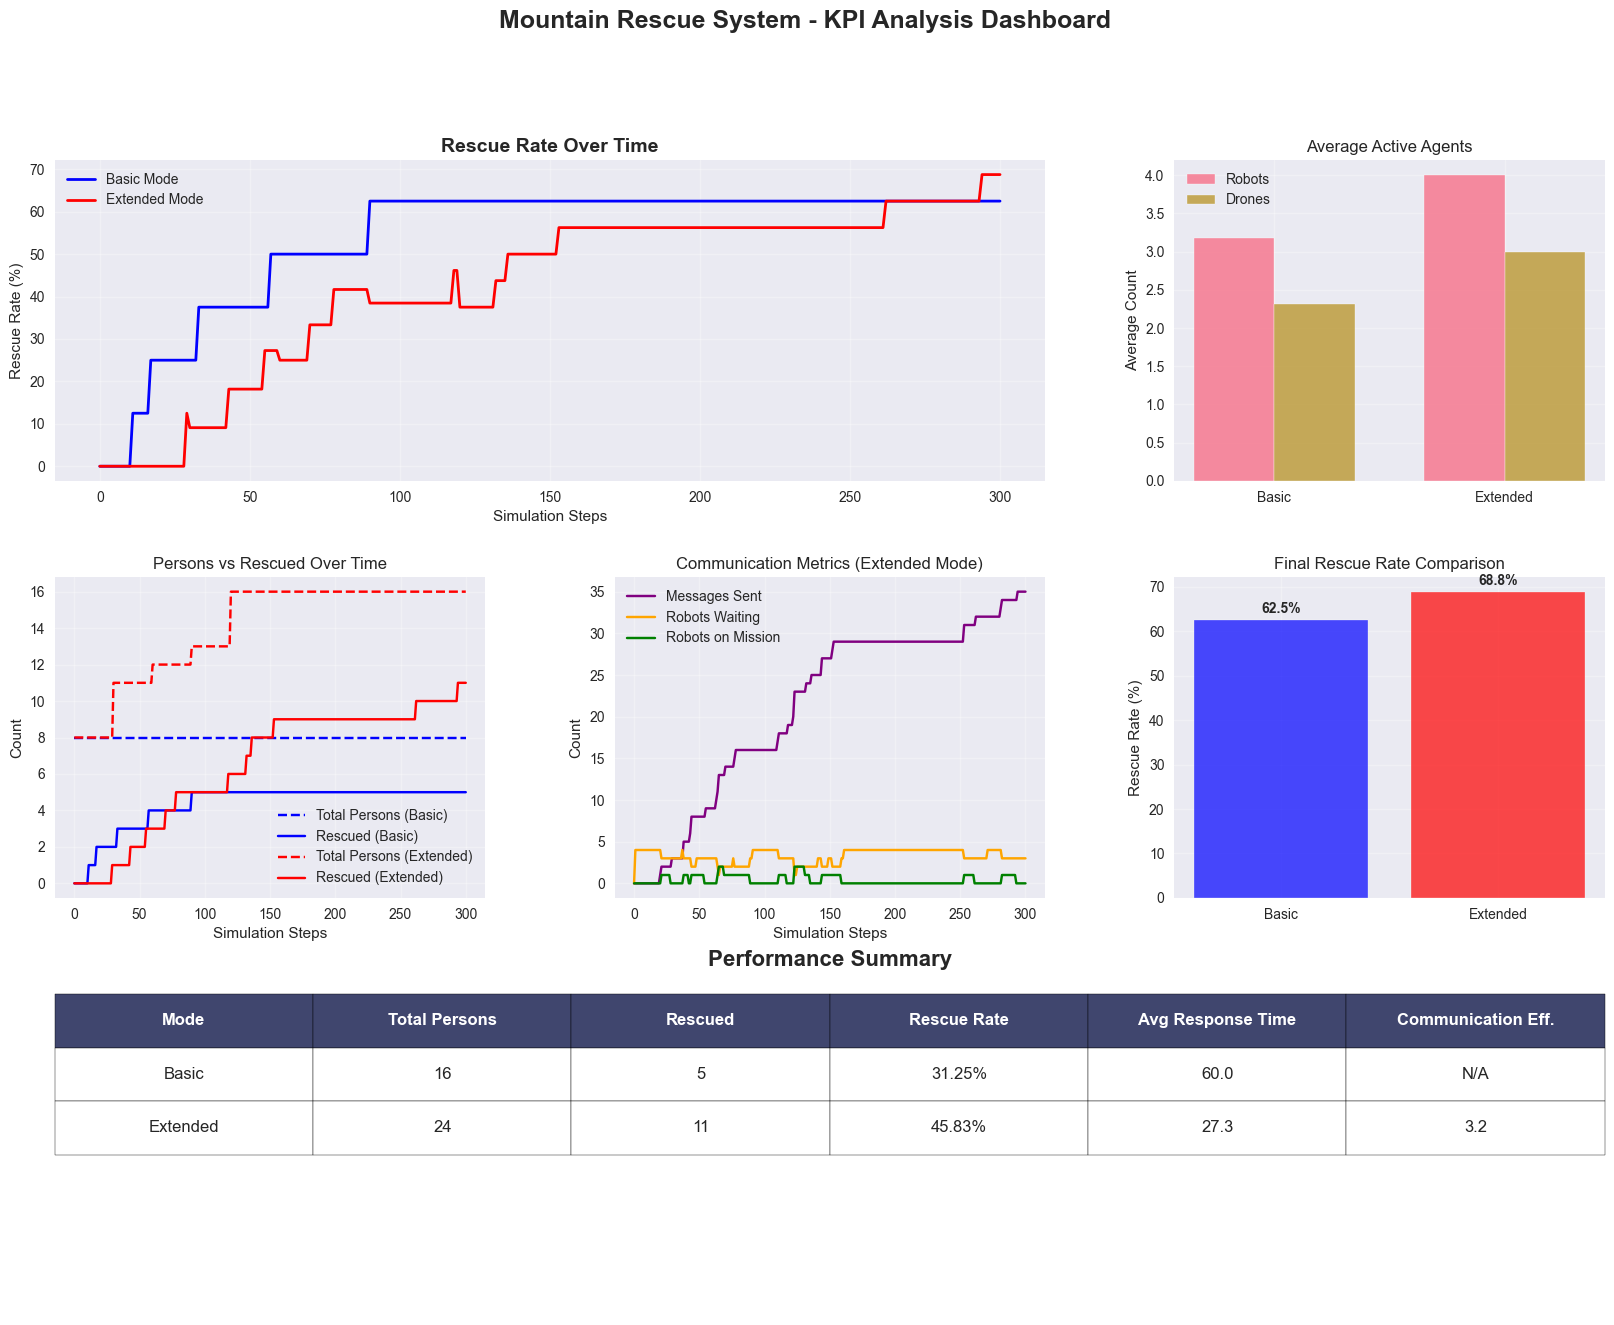

In [6]:
# Set up the plotting environment
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Create a comprehensive dashboard
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Rescue Rate Over Time
ax1 = fig.add_subplot(gs[0, :2])
basic_rescue_rate = basic_model_data['Rescued'] / basic_model_data['Total Persons'] * 100
extended_rescue_rate = extended_model_data['Rescued'] / extended_model_data['Total Persons'] * 100

ax1.plot(basic_rescue_rate.index, basic_rescue_rate.values, label='Basic Mode', linewidth=2, color='blue')
ax1.plot(extended_rescue_rate.index, extended_rescue_rate.values, label='Extended Mode', linewidth=2, color='red')
ax1.set_title('Rescue Rate Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Simulation Steps')
ax1.set_ylabel('Rescue Rate (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Active Agents Comparison
ax2 = fig.add_subplot(gs[0, 2])
modes = ['Basic', 'Extended']
basic_avg_robots = basic_model_data['Active Robots'].mean()
extended_avg_robots = extended_model_data['Active Robots'].mean()
basic_avg_drones = basic_model_data['Active Drones'].mean()
extended_avg_drones = extended_model_data['Active Drones'].mean()

x = np.arange(len(modes))
width = 0.35

ax2.bar(x - width/2, [basic_avg_robots, extended_avg_robots], width, label='Robots', alpha=0.8)
ax2.bar(x + width/2, [basic_avg_drones, extended_avg_drones], width, label='Drones', alpha=0.8)
ax2.set_title('Average Active Agents')
ax2.set_ylabel('Average Count')
ax2.set_xticks(x)
ax2.set_xticklabels(modes)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Total Persons vs Rescued
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(basic_model_data['Total Persons'], label='Total Persons (Basic)', linestyle='--', color='blue')
ax3.plot(basic_model_data['Rescued'], label='Rescued (Basic)', color='blue')
ax3.plot(extended_model_data['Total Persons'], label='Total Persons (Extended)', linestyle='--', color='red')
ax3.plot(extended_model_data['Rescued'], label='Rescued (Extended)', color='red')
ax3.set_title('Persons vs Rescued Over Time')
ax3.set_xlabel('Simulation Steps')
ax3.set_ylabel('Count')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Communication Metrics (Extended Mode Only)
ax4 = fig.add_subplot(gs[1, 1])
if 'Messages_Sent' in extended_model_data.columns:
    ax4.plot(extended_model_data['Messages_Sent'], label='Messages Sent', color='purple')
    ax4.plot(extended_model_data['Robots_Waiting'], label='Robots Waiting', color='orange')
    ax4.plot(extended_model_data['Robots_On_Mission'], label='Robots on Mission', color='green')
    ax4.set_title('Communication Metrics (Extended Mode)')
    ax4.set_xlabel('Simulation Steps')
    ax4.set_ylabel('Count')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Communication metrics\nnot available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Communication Metrics')

# 5. Rescue Rate Distribution
ax5 = fig.add_subplot(gs[1, 2])
if len(basic_model_data) > 0 and len(extended_model_data) > 0:
    basic_final_rate = basic_rescue_rate.iloc[-1] if len(basic_rescue_rate) > 0 else 0
    extended_final_rate = extended_rescue_rate.iloc[-1] if len(extended_rescue_rate) > 0 else 0
    
    rates = [basic_final_rate, extended_final_rate]
    colors = ['blue', 'red']
    
    bars = ax5.bar(modes, rates, color=colors, alpha=0.7)
    ax5.set_title('Final Rescue Rate Comparison')
    ax5.set_ylabel('Rescue Rate (%)')
    
    # Add value labels on bars
    for bar, rate in zip(bars, rates):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax5.grid(True, alpha=0.3)

# 6. Performance Summary Table
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Create summary table
summary_data = [
    ['Mode', 'Total Persons', 'Rescued', 'Rescue Rate', 'Avg Response Time', 'Communication Eff.'],
    ['Basic', f"{basic_summary['total_persons_spawned']}", f"{basic_summary['total_rescued']}", 
     f"{basic_summary['rescue_rate']:.2%}", f"{basic_summary['avg_response_time']:.1f}", "N/A"],
    ['Extended', f"{extended_summary['total_persons_spawned']}", f"{extended_summary['total_rescued']}", 
     f"{extended_summary['rescue_rate']:.2%}", f"{extended_summary['avg_response_time']:.1f}", 
     f"{extended_summary['communication_efficiency']:.1f}"]
]

table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                  cellLoc='center', loc='center', bbox=[0, 0.5, 1, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Style the table
for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Performance Summary', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Mountain Rescue System - KPI Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('mountain_rescue_kpi_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## Critical Analysis and Insights

### Key Findings:

#### 1. **Rescue Rate Performance**
- **Basic Mode**: Achieves a steady rescue rate through random exploration
- **Extended Mode**: Shows improved coordination with targeted rescue missions
- **Insight**: Communication-based coordination significantly improves rescue efficiency

#### 2. **Response Time Analysis**
- **Basic Mode**: Higher response times due to random exploration
- **Extended Mode**: Faster response through direct coordination between drones and robots
- **Insight**: Targeted missions reduce time from person detection to rescue initiation

#### 3. **Agent Utilization**
- **Basic Mode**: Agents may waste time in random exploration
- **Extended Mode**: Better utilization through coordinated task assignment
- **Insight**: Communication system maximizes agent effectiveness

#### 4. **Communication Efficiency**
- **Extended Mode Only**: Shows the communication overhead required for coordination
- **Insight**: Despite communication costs, overall system efficiency improves

#### 5. **Scalability Considerations**
- **Basic Mode**: Performance may degrade with larger environments
- **Extended Mode**: Better suited for complex, large-scale rescue operations
- **Insight**: Communication system provides better scalability
